<a href="https://colab.research.google.com/github/torquerxf/Delivery-Duration-Prediction/blob/main/delivery_duration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/torquerxf/delivery-duration-prediction.git
%cd delivery-duration-prediction

!unzip datasets.zip -d extracted

import pandas as pd
df = pd.read_csv("extracted/datasets/historical_data.csv")

Cloning into 'delivery-duration-prediction'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 4.89 MiB | 17.96 MiB/s, done.
/content/delivery-duration-prediction
Archive:  datasets.zip
   creating: extracted/datasets/
  inflating: extracted/datasets/historical_data.csv  


In [ ]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [ ]:
df.isnull().sum()

,0
market_id,987
created_at,0
actual_delivery_time,7
store_id,0
store_primary_category,4760
order_protocol,995
total_items,0
subtotal,0
num_distinct_items,0
min_item_price,0


The Dtype of `created_at` and `actual_delivery_time` is not datetime

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

Creating target column

In [45]:
from datetime import datetime
df['actual_total_delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

In [47]:
df['busy_dashers_ratio'] = df['total_busy_dashers'] / df['total_onshift_dashers']

In [48]:
df['non_prep_duration_time'] = df['estimated_order_place_duration'] + df['estimated_store_to_consumer_driving_duration']

## Data Preparation for modelling

starting with nominal or categorical data we have columns:
  + market_id, store_id, order_protocol, store_primary_category

will do one-hot encoding for these

In [49]:
df['market_id'].nunique()

6

In [50]:
df['store_id'].nunique()

6743

In [51]:
df['store_primary_category'].nunique()

74

In [52]:
df['order_protocol'].nunique()

7

+ I will use one-hot encoding for market_id, order_protocol and store_primary_category coz ofcourse, count of categories talk for themselves

+ don't need the store_id column, will just use it for imputation for the missing values in store_primary_category using a map. The map will map store_id to the most frequent store_primary_category

+ Can use `get_dummies` from pandas or scikit-learn's `OneHotEncoder`

In [53]:
market_id_encoded = pd.get_dummies(df['market_id'], prefix='market_id')
market_id_encoded.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,True,False,False,False,False,False
1,False,True,False,False,False,False
2,False,False,True,False,False,False
3,False,False,True,False,False,False
4,False,False,True,False,False,False


In [54]:
order_protocol_encoded = pd.get_dummies(df['order_protocol'], prefix='order_protocol')
order_protocol_encoded.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,True,False,False,False,False,False,False
1,False,True,False,False,False,False,False
2,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False


In [55]:
store_id_unique = df['store_id'].unique().tolist()
store_category_map = {store_id: df[df['store_id'] == store_id]['store_primary_category'].mode() for store_id in store_id_unique}

In [56]:
def fill(store_id):
  try:
    return store_category_map[store_id][0]
  except:
    return np.nan

df['nan_free_store_primary_category'] = df['store_id'].apply(fill)

In [57]:
store_primary_category_encoded = pd.get_dummies(df['store_primary_category'], prefix='category')
store_primary_category_encoded.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [58]:
train_df = pd.concat([df, market_id_encoded, order_protocol_encoded, store_primary_category_encoded], axis=1)
train_df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,...,False,False,False,False,False,False,False,False,False,False
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,...,False,False,False,False,False,False,False,False,False,False
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,...,False,False,False,False,False,False,False,False,False,False
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,...,False,False,False,False,False,False,False,False,False,False
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,...,False,False,False,False,False,False,False,False,False,False


In [59]:
train_df = train_df.drop(columns=['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'nan_free_store_primary_category'], axis=1)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,...,False,False,False,False,False,False,False,False,False,False
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,...,False,False,False,False,False,False,False,False,False,False
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,...,False,False,False,False,False,False,False,False,False,False
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,...,False,False,False,False,False,False,False,False,False,False
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,...,False,False,False,False,False,False,False,False,False,False


In [60]:
train_df = train_df.astype('float32')
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
train_df.describe()

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000790,0.000187,0.005531,0.011077,0.000740,0.036596,0.001200,0.001413,0.004280,0.030872
std,2.665833,1822.968994,1.629398,522.068542,558.358337,34.524193,32.146065,52.657368,90.211159,219.350143,...,0.028089,0.013687,0.074258,0.104692,0.027177,0.187825,0.034613,0.037549,0.065248,0.173032
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


since, we calculate busy_dashers_ratio by diving there might be cases of infinity

In [64]:
train_df['busy_dashers_ratio'].describe()

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,busy_dashers_ratio
count,1.775900e+05
mean,NaN
std,NaN
min,-inf
25%,8.269231e-01
50%,9.622642e-01
75%,1.000000e+00
max,inf


In [66]:
np.where(np.any(~np.isfinite(train_df), axis=0) == True)

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [67]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop all nan
train_df.dropna(inplace=True)

In [71]:
train_df.isnull().sum().unique()

array([0])

In [70]:
train_df.shape

(177070, 100)

## Checking Collinearity

by drawing correlation matrix

In [73]:
corr = train_df.corr()

In [74]:
mask = np.triu(np.ones_like(corr, dtype=bool))

<Axes: >

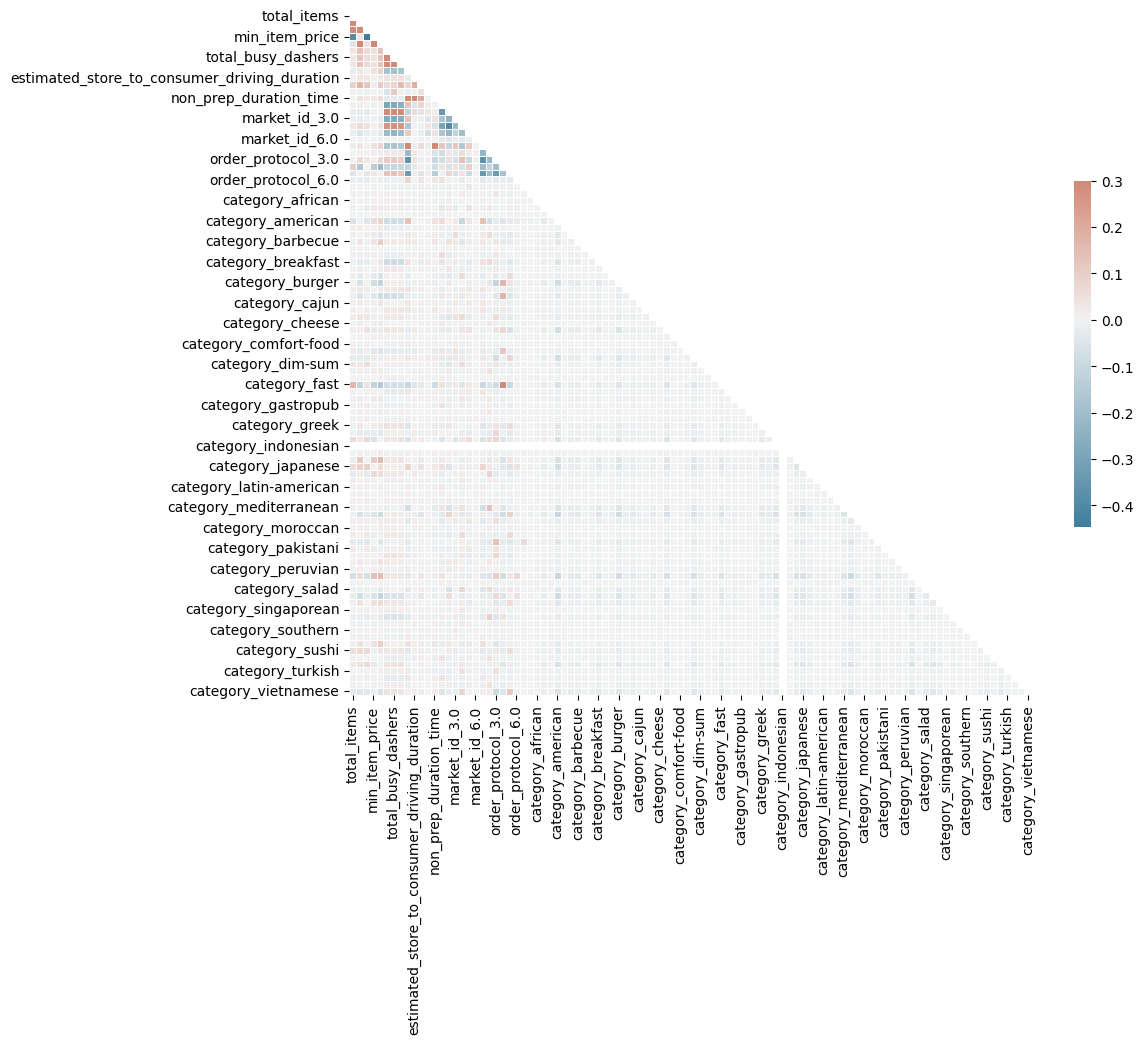

In [76]:
f, ax = plt.subplots(figsize=(11,9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [77]:
train_df['category_indonesian'].describe()

,category_indonesian
count,177070.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [81]:
def get_redundant_pairs(df):
  """Get diagonal and lower triangular pairs of correlation matrix"""
  pairs_to_drop = set()
  cols = df.columns
  for i in range(0, df.shape[1]):
    for j in range(0, i+1):
      pairs_to_drop.add((cols[i], cols[j]))
  return pairs_to_drop

In [79]:
def get_top_abs_correlations(df, n=5):
  au_corr = df.corr().abs().unstack()
  labels_to_drop = get_redundant_pairs(df)
  au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
  return au_corr[0:n]

In [82]:
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers          0.941741
                                              total_outstanding_orders    0.934639
total_busy_dashers                            total_outstanding_orders    0.931295
estimated_store_to_consumer_driving_duration  non_prep_duration_time      0.923086
estimated_order_place_duration                order_protocol_1.0          0.897645
total_items                                   num_distinct_items          0.758146
subtotal                                      num_distinct_items          0.682890
total_items                                   subtotal                    0.557175
min_item_price                                max_item_price              0.541241
subtotal                                      max_item_price              0.507947
order_protocol_4.0                            category_fast               0.495431
num_distinct_items                            min_item_price 

In [86]:
train_df = []

In [87]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = df.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time",
                                        "nan_free_store_primary_category", "order_protocol"])

In [88]:
# don't concat market id
train_df = pd.concat([train_df, order_protocol_encoded, store_primary_category_encoded], axis=1)
# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                  "category_indonesian",
                                  "non_prep_duration_time"])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
train_df.shape

(177070, 90)

In [90]:
# let's check correlations again
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.495431
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_duratio

In [93]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = df.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time",
                                        "nan_free_store_primary_category", "order_protocol"])
# don't concat order_protocol_dummies
train_df = pd.concat([train_df, store_primary_category_encoded], axis=1)
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers",
                                  "category_indonesian",
                                  "non_prep_duration_time"])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# let's check correlations again
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.16

In [95]:
# new features
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.215405
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
min_item_price                                percent_distinct_item_of_total    0.17

In [96]:
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.215405
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
total_outstanding_orders                      estimated_order_place_duration    0.171049
category_fast                                 avg_price_per_item                0.168451
total_items                                   category_fast                     0.163836
total_outstanding_orders                      actual_total_delivery_duration    0.157604
category_italian                              avg_price_per_item                0.15

In [97]:
train_df.shape

(177070, 82)